In [15]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt      
from datetime import datetime
from datetime import timedelta
import sklearn
from sklearn import preprocessing, linear_model, model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import matplotlib.pyplot as plt  
import seaborn as sns
from scipy.stats import boxcox
from sklearn.feature_selection import SelectKBest, f_regression

from ipynb.fs.full.set_up import data_prep
import joblib


In [16]:
def tune_model(X_train_scaled, y_train):
    params = {'fit_intercept': [True, False], 'positive': [True, False]}
    grid_search_cv = GridSearchCV(LinearRegression(), params, n_jobs=-1, verbose=1, cv=10)
    grid_search_cv.fit(X_train_scaled, y_train)
    best_params = grid_search_cv.best_params_
    best_score = grid_search_cv.best_score_
    return best_params, best_score

def return_best_model(X_train_scaled, y_train, best_params):
    reg = LinearRegression(**best_params)
    reg.fit(X_train_scaled, y_train)
    y_pred = reg.predict(X_test_scaled)
    return reg, y_pred


def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, r2



Prep
(51630, 26)
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best Parameters: {'fit_intercept': True, 'positive': False}
Best Score: 0.6633216135655211
MAE: 501251.81726058427
R2: 0.6890193401197768


<AxesSubplot:>

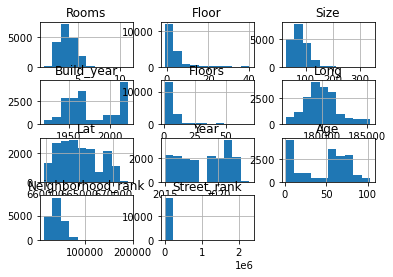

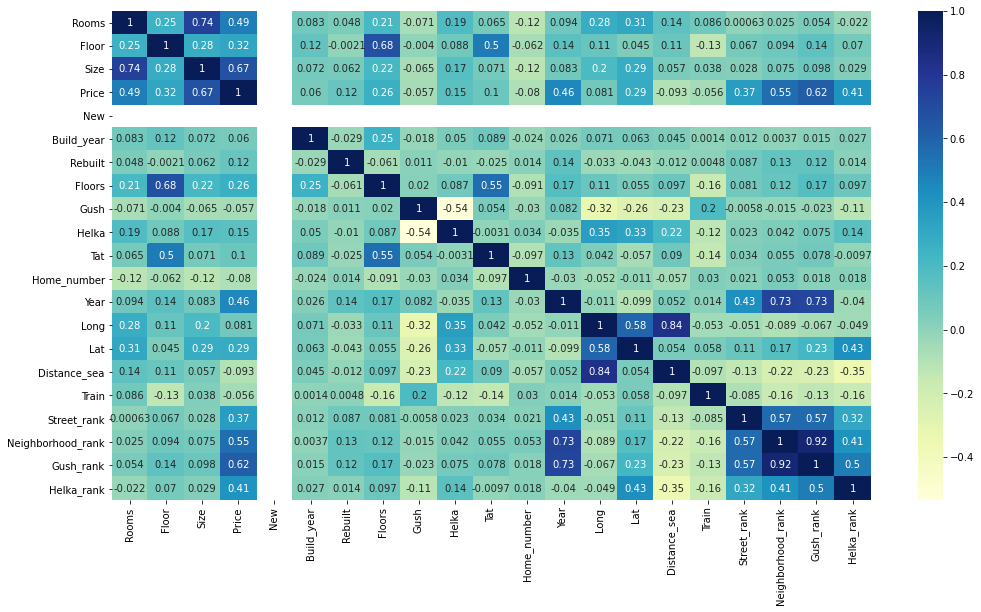

In [17]:
df = pd.read_csv("../Data/Nadlan_clean.csv",index_col=0)
df
#1. Prep the data
X_train_scaled,  X_test_scaled  ,y_train, y_test , X_train, X_test = data_prep(start_year = 2015 , min_price = 1000000 ,max_price =7000000 )

#2. Find best params

best_params, best_score = tune_model(X_train_scaled, y_train)

#3. Return Best Model
model, y_pred = return_best_model(X_train_scaled, y_train, best_params)
joblib.dump(model, 'linear_model.pkl')
#4. Evaluate Model
mae, r2 = evaluate_model(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("MAE:", mae)
print("R2:", r2)

X_train.hist()
plt.figure(figsize=(17,9))
# sns.heatmap(X_train.corr(), annot =True ,cmap ='YlGnBu')
sns.heatmap(df.corr(), annot =True ,cmap ='YlGnBu')


In [18]:
def recommend_affordable_apartments(df, model ,item_id):
    y = df['Price']
    X = df.drop('Price', axis=1)
    
    scaler = joblib.load('scaler.pkl')
#     scaler = MinMaxScaler()
    X_scaled = scaler.transform(X)
    
    # Predict prices using the trained model
    y_pred = model.predict(X_scaled)
    y_pred =y_pred *1.2
    df["Predicted"] = y_pred
    df["Predicted"] = df["Predicted"].astype(int)
    df['Difference'] =  df["Price"] -  df["Predicted"] 
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f'r2_score: {r2} , mae: {mae}')
    df['Item_id'] = item_id
    df["Predicted"] = df["Predicted"].astype(np.int32)
    df["Difference"] = df["Difference"].astype(np.int32)

    return df.sort_values(by="Difference")


yad2_df , item_id = data_prep(valid = True , accuracy = 80 ,min_price = 1000000 ,max_price =7000000) #, accuracy = 100
yad_2_results = recommend_affordable_apartments(yad2_df,model, item_id)
# r2_score: 0.16822520984641842 , mae: 935488.8606998131


Prep
(751, 30)
r2_score: -753.1470734916778 , mae: 18218751.849807106


In [19]:
df = pd.read_csv("../Data/yad_2_data.csv", index_col=0)
merged_df = pd.concat([df.set_index('Item_id'), yad2_df.set_index('Item_id')], axis=1, join='inner')
merged_df = merged_df.reset_index()
merged_df.index += 1
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
merged_df = merged_df.drop_duplicates(subset='Item_id')

cols = ['Text']
# merged_df.to_csv('../Data/Predicted_DB.csv') 

merged_df.drop(columns = cols, inplace = True)


In [20]:
merged_df.sort_values(by="Difference")

,Item_id,Street,Neighborhood,Parking,Balconies,Size,Floors,Asset_classification,Ac,Furniture,...,Date,Last_update,Price,Build_year,Year,Age,Neighborhood_rank,Street_rank,Predicted,Difference
104,m7jbksv4,יסוד המעלה,נווה שאנן,1,1.0,174.0,7.0,1.0,1.0,0.0,...,NaN,NaN,4000000,1984,2023,39,53710,44659,6454820,-2454820
422,wl2momep,טשרניחובסקי,"לב תל אביב, לב העיר צפון",ללא,2.0,90.0,3.0,2.0,1.0,0.0,...,NaN,NaN,2500000,1935,2023,88,59306,71196,4798200,-2298200
14,1xts9is0,טשרניחובסקי,"לב תל אביב, לב העיר צפון",ללא,2.0,90.0,3.0,2.0,1.0,0.0,...,NaN,NaN,2500000,1935,2023,88,59306,71196,4798200,-2298200
333,8w0i3w1z,החשמונאים,"גני שרונה, קרית הממשלה",2,1.0,128.0,50.0,6.0,1.0,1.0,...,NaN,NaN,5250000,1954,2023,69,62314,63638,7229344,-1979344
164,77n531kv,החשמונאים,"גני שרונה, קרית הממשלה",2,1.0,98.0,50.0,6.0,1.0,1.0,...,NaN,NaN,4390000,1954,2023,69,62314,63638,6275928,-1885928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,12mxe8bn,בוקי בן יגלי,"לב תל אביב, לב העיר צפון",1,0.0,75.0,3.0,2.0,1.0,0.0,...,NaN,NaN,5500000,1970,2023,53,59306,26250,-60107045,65607045
459,gdm02lnj,אלכסנדר ינאי,הצפון הישן - צפון,1,1.0,114.0,5.0,3.0,1.0,0.0,...,NaN,NaN,6920000,1950,2023,73,58284,61682,-58926851,65846851
306,h7orqzn6,הירקון,הצפון הישן - דרום,1,1.0,63.0,6.0,6.0,1.0,1.0,...,NaN,NaN,5300000,1960,2023,63,58284,66831,-60553337,65853337
371,4dcpdbxo,רפידים,מעוז אביב,ללא,0.0,79.0,3.0,3.0,0.0,0.0,...,NaN,NaN,5200000,1962,2023,61,40972,40512,-60830851,66030851
